# Estimation of MET cross section with Madgraph 3.6.2

## Import MG5 and dependencies

In [5]:
import os
import sys

sys.path.append('../src') # Only if madpy is not installed

MADGRAPH_PATH = f"../mg5amcnlo"
sys.path.append(MADGRAPH_PATH)

from madgraph.interface.master_interface import MasterCmd

mg = MasterCmd()

Note that this is a development version.
This version is intended for development/beta testing and NOT for production.
This version has not been fully tested (if at all) and might have limited user support (if at all)


In [ ]:
# Import SM model to check if it's working
mg.exec_cmd("import model sm")


## Install models and plugins

### [DMSimp](https://feynrules.irmp.ucl.ac.be/wiki/DMsimp)

Simplified DM extension with a scalar mediator and three DM candidates

In [ ]:
### DMSimp
# - https://feynrules.irmp.ucl.ac.be/wiki/DMsimp 

mg.exec_cmd("import model DMsimp_s_spin0")
#from madgraph.core.base_objects import Model
# PDG number 9000001 to particle ghA
# PDG number 9000002 to particle ghZ
# PDG number 9000003 to particle ghWp
# PDG number 9000004 to particle ghWm
# g ghg ghg~ u c d s b u~ c~ d~ s~ b~ a gha gha~ ve vm vt e- mu- ve~ vm~ vt~ e+ mu+ t t~ z w+ ghz ghwp ghwm h xr xc y0 w- ghz~ ghwp~ ghwm~ xc~ ta- xd ta+ xd~

Xr = {'name': 'xr',
      'pdg_code': 5000001} # real scalar DM
Xc = {'name': 'xc',
      'pdg_code': 51} # complex scalar DM

Xd = {'name': 'xd',
      'pdg_code': 52} # dirac DM DM

Y0 = {'name': 'y0',
      'pdg_code': 54} # real scalar DM

# TODO: Seems like Xv (vector) needs to be implemented. Search for complementary model


Pass the definition of 'j' and 'p' to 5 flavour scheme.


In [31]:
mg.exec_cmd("import model DMsimp_s_spin0")

In [ ]:
sys.path.append('../')

In [ ]:
## Write and execute an script for mg5


script_file_name = "new_process.mg5" ## the *.mg5 file extension is optional
workdir_path = "../workdir"
process_dir = "new_process"
workdir_process = f"{workdir_path}/{process_dir}"

# import model DMsimp_s_spin0
# generate p p > xd xd~ a / a z [QCD]
## Generate files at output
# set param_card mass 5000001  1.720000e+02
# launch {workdir_process} -i
#     print_results --path=./cross_section_top.txt --format=short
## scan or scan1 (for zip combinations)

mg5_script = f"""\
generate p p > t t~ j
output {workdir_process} -f
launch {workdir_process}
    set mass mt scan:[170,175,180, 190, 200]
    set decay wt Auto # changing the top width
    set ptj 40 # changing the ptj cut
    madspin=ON
    set nevents 1k
"""

with open(script_file_name, "w") as script_file:
    script_file.write(mg5_script)

In [ ]:
mg5_executable = f"{MADGRAPH_PATH}/bin/mg5_aMC"
# executable rather than the "./bin/madevent" one

In [ ]:
import subprocess
from subprocess import Popen, PIPE, CalledProcessError

def madpy_generate_script(process: str = "p p > t t~ j",
                          model: str = "sm",
                          masses: dict | None = {"mt": "scan:[190, 200]"},
                          decays: dict | None = {"wt": "Auto"},
                          pt_cut: dict | None = {"ptj": "40"},
                          madspin: bool = True,
                          number_events: int = 1000,
                          script_file_name: str = "new_process.mg5",
                          workdir_path: str = "../workdir",
                          process_dir: str = "new_process"):
    
    workdir_process = f"{workdir_path}/{process_dir}"
    
    mg5_script = f"""\
import model {model}
generate {process}
output {workdir_process} -f
launch {workdir_process}"""
    
    if masses:
        for particle, mass in masses.items():
            mg5_script += "\n\t" + f"""set mass {particle} {mass}"""
    
    if decays:
        for decay, value in decays.items():
            mg5_script += "\n\t" + f"""set width {decay} {value}"""
    
    if pt_cut:
        for pt, cut in pt_cut.items():
            mg5_script +=  "\n\t" + f"""set {pt} {cut}"""
    
    if madspin:
        mg5_script += "\n\t" + f"""madspin=ON"""
        
    # Set number of events
    mg5_script += "\n\t" + f"""set nevents {number_events}"""
    
    with open(script_file_name, "w") as script_file:
        script_file.write(mg5_script)
        
    return mg5_script, script_file_name
    
def madpy_run(mg5_script_path: str, mg5_bin: str = "mg5_aMC", madgraph_path = MADGRAPH_PATH):
    
    mg5_executable = f"{madgraph_path}/bin/{mg5_bin}"
    subprocess.run([mg5_executable, mg5_script_path])



In [107]:
# Generate script
full_script_str, mg5_script_path = madpy_generate_script(process = "p p > Y0 > xd xd~ a",
                                                         model = "DMsimp_s_spin0",
                                                         script_file_name = "dm_process.mg5",
                                                         process_dir= "dmsimp_v1",
                                                        masses = {"mxd": "scan:[500, 1000]"},
                                                        decays = {"9000001": "Auto",
                                                                  "9000002": "Auto",
                                                                  "9000003": "Auto",
                                                                  "9000004": "Auto"},
                                                        pt_cut = None,
                                                        madspin = False,
                                                        number_events = 10000,
                                                         )



In [ ]:
madpy_run(mg5_script_path)





Running MG5 in debug mode


Note that this is a development version.
This version is intended for development/beta testing and NOT for production.
This version has not been fully tested (if at all) and might have limited user support (if at all)


************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.6.3                 2025-06-12         *
*                                                          *
*          WARNING: UNKNOWN DEVELOPMENT VERSION.           *
*            WARNING: DO NOT USE FOR PRODUCTION            *
*                       

stty: 'standard input': Inappropriate ioctl for device
Note that this is a development version.
This version is intended for development/beta testing and NOT for production.
This version has not been fully tested (if at all) and might have limited user support (if at all)


INFO: get decay diagram for ghwp 
INFO: get decay diagram for ghwm 
No three body-decay (or higher) is found for {9000002, 9000003, 9000004}
No need for N body-decay (N>2). Results are in /home/mjrxy/MadPy/workdir/dmsimp_v1/Cards/param_card.dat
INFO: Update the dependent parameter of the param_card.dat 
Generating 10000 events with run name run_01
survey  run_01 
INFO: compile directory 
Not able to open file /home/mjrxy/MadPy/workdir/dmsimp_v1/crossx.html since no program configured.Please set one in ./input/mg5_configuration.txt
write compile file for card: /home/mjrxy/MadPy/workdir/dmsimp_v1/Cards/param_card.dat
run_card missed argument polbeam1. Takes default: 0.0
run_card missed argument polbeam2. Takes default: 0.0
run_card missed argument nb_proton1. Takes default: 1
run_card missed argument nb_proton2. Takes default: 1
run_card missed argument nb_neutron1. Takes default: 0
run_card missed argument nb_neutron2. Takes default: 0
run_card missed argument mass_ion1. Takes default: 

100%|█████████████████████████████████████| 769/769 [00:00<00:00, 86679.20it/s]


INFO:  Idle: 1,  Running: 1,  Completed: 0 [ current time: 17h55 ] 
INFO:  Idle: 0,  Running: 1,  Completed: 1 [  0.32s  ] 
INFO:  Idle: 0,  Running: 0,  Completed: 2 [  0.65s  ] 
INFO: End survey 
refine 10000
Creating Jobs
INFO: Refine results to 10000 
INFO: Generating 10000.0 unweighted events. 
sum of cpu time of last step: 1 seconds
INFO: Effective Luminosity 10168198957.759607 pb^-1 
DEBUG: channel G2.7 need to improve by 2.47 (xsec=1.0509e-07 pb, iter=3) 
DEBUG: channel G2.8 need to improve by 5.30 (xsec=2.1309e-07 pb, iter=3) 
DEBUG: channel G1 need to improve by 22.65 (xsec=8.6197e-07 pb, iter=3) 
INFO: need to improve 3 channels 
DEBUG: G2.7 : need 1068.576028470957 event. Need 2 split job of 1235 points 
DEBUG: G2.8 : need 2166.7415159089946 event. Need 3 split job of 1768 points 
DEBUG: G1 : need 8764.682455620048 event. Need 9 split job of 2519 points 
- Current estimate of cross-section: 1.18015e-06 +- 1.804163759917597e-08
    P1_qq_xdxdxa 
INFO:  Idle: 1,  Running: 13,

Note that this is a development version.
This version is intended for development/beta testing and NOT for production.
This version has not been fully tested (if at all) and might have limited user support (if at all)


INFO: get decay diagram for ghwp 
INFO: get decay diagram for ghwm 
No three body-decay (or higher) is found for {9000002, 9000003, 9000004}
No need for N body-decay (N>2). Results are in /home/mjrxy/MadPy/workdir/dmsimp_v1/Cards/param_card.dat
INFO: Update the dependent parameter of the param_card.dat 
Generating 10000 events with run name run_02
survey  run_02 
INFO: compile directory 
write compile file for card: /home/mjrxy/MadPy/workdir/dmsimp_v1/Cards/param_card.dat
run_card missed argument polbeam1. Takes default: 0.0
run_card missed argument polbeam2. Takes default: 0.0
run_card missed argument nb_proton1. Takes default: 1
run_card missed argument nb_proton2. Takes default: 1
run_card missed argument nb_neutron1. Takes default: 0
run_card missed argument nb_neutron2. Takes default: 0
run_card missed argument mass_ion1. Takes default: -1.0
run_card missed argument mass_ion2. Takes default: -1.0
run_card missed argument pdlabel1. Takes default: nn23lo1
run_card missed argument pd

In [ ]:
   # Same cross section, different errors bars :] 
    #     Cross-section :   0.0003166 +- 5.396e-07 pb
    #  Nb of events :  10000
    # Cross-section :   0.0003185 +- 1.277e-06 pb
    #  Nb of events :  1000
    # #  Cross-section :   0.0003163 +- 2.277e-06 pb
    # #  Nb of events :  500
    
    
# TODO: Compare a useful cross section with those I have!!!
# TODO: Learn how to parallize those jobs

### Show diagrams here [? how ?]

In [13]:
mg.draw('myHiggsProc')

Not able to open file myHiggsProc/diagrams_0_uux_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt
Not able to open file myHiggsProc/diagrams_0_ddx_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt


In [8]:
mg.exec_cmd("display diagrams")

Not able to open file /tmp/diagrams_0_uux_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt
Not able to open file /tmp/diagrams_0_ddx_a_ttx.eps since no program configured.Please set one in ./input/mg5_configuration.txt


In [18]:
import glob
from IPython.display import Image, display

diagram_files = sorted(glob.glob("myHiggsProc/HTML/diagram*.png"))

for f in diagram_files:
    display(Image(filename=f))

## Read generated files

In [1]:
!python -m pip install pylhe


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import awkward
awkward.__version__

'1.10.5'

'1.10.5'

In [3]:
!export PYTHONPATH=/opt/apps/python/3.10/lib/:/home/mjrxy/py_phenoenv

In [6]:
!source /home/mjrxy/py_phenoenv/bin/activate

In [4]:
!echo $PYTHONPATH

/home/mjrxy/.local/lib/python3.10/site-packages:/opt/apps/root/lib:/opt/apps/root/lib:/home/mjrxy/.local/lib/python3.10/site-packages:/home/mjrxy/sprace/ttZanalysis/pepper:/home/mjrxy/heppy


In [7]:
import itertools

# You can use LHE files from scikit-hep-testdata

import pylhe

lhe_file = '/home/mjrxy/MadPy/workdir/new_process/Events/run_02/unweighted_events.lhe'
events = pylhe.read_lhe_with_attributes(lhe_file)
print(f"Number of events: {pylhe.read_num_events(lhe_file)}")


WARNING. Parse Error: not well-formed (invalid token): line 48, column 0
Number of events: -1


In [8]:

# Get event 1
event = next(itertools.islice(events, 1, 2))

WARNING. Parse Error: not well-formed (invalid token): line 48, column 0


StopIteration: 

In [ ]:

# Get event 1
event = next(itertools.islice(events, 1, 2))

# A DOT language graph of the event can be inspected as follows
print(event.graph.source)

# The graph is nicely displayed as SVG in Jupyter notebooks
event

# To save a DOT graph render the graph to a supported image format
# (refer to the Graphviz documentation for more)
event.graph.render(filename="test", format="png", cleanup=True)
event.graph.render(filename="test", format="pdf", cleanup=True)

In [5]:
import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lhe_file = '/home/mjrxy/MadPy/workdir/new_process/Events/run_02/unweighted_events.lhe.gz'
def unpack_events(events_path):
    # Caminho para o arquivo de saída com eventos gerados
    output_file = events_path # os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe")
    try:
        #output_zip_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe.gz")
        subprocess.run(["gzip", "-d", output_file])
        print("Arquivo LHE descompactado com sucesso.")
    except FileNotFoundError:
        print('Arquivo ja foi descompactado')

unpack_events(lhe_file)

Arquivo LHE descompactado com sucesso.


In [9]:
import pandas as pd

# Criação da tabela de referência de partículas
particle_data = {
    "PID": [11, -11, 13, -13, 22, 12, -12, 14, -14, 16, -16, 1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 21, 23, 24, -24],
    "Name": [
        "Electron", "Positron", "Muon", "Anti-Muon", "Photon",
        "Electron Neutrino", "Electron Anti-Neutrino", "Muon Neutrino", "Muon Anti-Neutrino",
        "Tau Neutrino", "Tau Anti-Neutrino", "Down Quark", "Anti-Down Quark",
        "Up Quark", "Anti-Up Quark", "Strange Quark", "Anti-Strange Quark",
        "Charm Quark", "Anti-Charm Quark", "Bottom Quark", "Anti-Bottom Quark",
        "Gluon", "Z Boson", "W+ Boson", "W- Boson"
    ],
    "Symbol": [
        "e-", "e+", "mu-", "mu+", "a",
        "ve", "ve~", "vm", "vm~",
        "vt", "vt~", "d", "d~",
        "u", "u~", "s", "s~",
        "c", "c~", "b", "b~",
        "g", "z", "w+", "w-"
    ]
}

# Criação do DataFrame com as informações de partículas
particle_df = pd.DataFrame(particle_data)
particle_df.to_csv('particle_names.csv', index=False)
print(particle_df)

    PID                    Name Symbol
0    11                Electron     e-
1   -11                Positron     e+
2    13                    Muon    mu-
3   -13               Anti-Muon    mu+
4    22                  Photon      a
5    12       Electron Neutrino     ve
6   -12  Electron Anti-Neutrino    ve~
7    14           Muon Neutrino     vm
8   -14      Muon Anti-Neutrino    vm~
9    16            Tau Neutrino     vt
10  -16       Tau Anti-Neutrino    vt~
11    1              Down Quark      d
12   -1         Anti-Down Quark     d~
13    2                Up Quark      u
14   -2           Anti-Up Quark     u~
15    3           Strange Quark      s
16   -3      Anti-Strange Quark     s~
17    4             Charm Quark      c
18   -4        Anti-Charm Quark     c~
19    5            Bottom Quark      b
20   -5       Anti-Bottom Quark     b~
21   21                   Gluon      g
22   23                 Z Boson      z
23   24                W+ Boson     w+
24  -24                W-

In [10]:
import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MG_VERSION = "v3_6_2"




# Função para extrair a seção transversal (cross-section) do arquivo LHE
def get_cross_section(lhe_file):
    cross_section = None
    with open(lhe_file, 'r') as file:
        in_init_block = False
        for line in file:
            if "<init>" in line:
                in_init_block = True
            elif "</init>" in line:
                in_init_block = False
                break
            elif in_init_block:
                data = line.strip().split()
                if len(data) <= 6:
                    cross_section = float(data[0]) 
                    error = float(data[1])
                    break
    return cross_section, error

# Função para ler o arquivo LHE e converter para um DataFrame do Pandas, incluindo ID do evento
def parse_lhe_file(file_path, cross_section, error):
    events = []
    event_id = 0

    with open(file_path, 'r') as file:
        in_event = False
        for line in file:
            if "<event>" in line:
                in_event = True
                event = []
                event_id += 1  # Incrementa o ID do evento a cada novo evento
            elif "</event>" in line:
                in_event = False
                events.append(event)
            elif in_event:
                data = line.strip().split()
                if len(data) >= 6:
                    try:
                        particle_data = list(map(float, data))
                        particle_data.append(event_id)  # Adiciona o ID do evento à partícula
                        event.append(particle_data)
                    except ValueError:
                        print('error in line', data)
                        pass
                                    
    # Converte a lista de eventos para um DataFrame
    columns = ["PID", "status", "Mmother1", "mother2", "color1", "color2", "px", "py", "pz", "E", "M", "Lifetime", "Spin", "Event_ID"]
    df = pd.DataFrame([item for sublist in events for item in sublist], columns=columns)
    # Adiciona uma coluna de cross-section (mesmo valor para todos os eventos)
    df["cross_section"] = cross_section #pb
    df['cross_section_error'] = error #± pb
    return df

# Extraia a cross-section do arquivo LHE
output_file = '/home/mjrxy/MadPy/workdir/new_process/Events/run_02/unweighted_events.lhe'
cross_section_value, cross_section_error = get_cross_section(output_file)

# Parse o arquivo LHE e crie o DataFrame com a seção transversal e ID do evento
if cross_section_value:
    df_events = parse_lhe_file(output_file, cross_section_value, cross_section_error)
    df_events = df_events.dropna(subset='E').reset_index(drop=True)
    df_events = df_events.merge(particle_df, on='PID', how='left')
    #print(df_events.head())
    # df_events.to_pickle(working_dir + '/' + event_name + '/df_events.pkl')
else:
    print("Cross-section not found in the file.")

#return df_events


error in line ['<pdfrwt', 'beam="1">', '1', '21', '0.38260291E+00', '0.37641747E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="2">', '1', '21', '0.17212629E-01', '0.37641747E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="1">', '1', '21', '0.59182332E-01', '0.18962523E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="2">', '1', '21', '0.47322401E-01', '0.18962523E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="2">', '1', '21', '0.58430565E-01', '0.21663550E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="1">', '1', '1', '0.16344842E+00', '0.21663550E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="1">', '1', '21', '0.11411664E-01', '0.47158904E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="2">', '1', '2', '0.73348447E+00', '0.47158904E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="1">', '1', '21', '0.21728916E+00', '0.24444191E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="2">', '1', '21', '0.12271796E-01', '0.24444191E+03</pdfrwt>']
error in line ['<pdfrwt', 'beam="2">', '1', '21', '0

In [11]:
df_events

,PID,status,Mmother1,mother2,color1,color2,px,py,pz,E,M,Lifetime,Spin,Event_ID,cross_section,cross_section_error,Name,Symbol
0,21.0,-1.0,0.0,0.0,504.0,502.0,0.000000,0.000000,2486.919172,2486.919172,0.0,0.0,-1.0,1.0,308.5585,1.135665,Gluon,g
1,21.0,-1.0,0.0,0.0,501.0,503.0,-0.000000,-0.000000,-111.882078,111.882078,0.0,0.0,1.0,1.0,308.5585,1.135665,Gluon,g
2,6.0,1.0,1.0,2.0,501.0,0.0,-65.509140,209.775617,333.377876,435.962229,175.0,0.0,1.0,1.0,308.5585,1.135665,NaN,NaN
3,-6.0,1.0,1.0,2.0,0.0,502.0,117.001684,-366.518354,1896.683054,1943.207839,175.0,0.0,-1.0,1.0,308.5585,1.135665,NaN,NaN
4,21.0,1.0,1.0,2.0,504.0,503.0,-51.492544,156.742737,144.976164,219.631181,0.0,0.0,1.0,1.0,308.5585,1.135665,Gluon,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,21.0,-1.0,0.0,0.0,503.0,502.0,0.000000,0.000000,1174.194162,1174.194162,0.0,0.0,1.0,10000.0,308.5585,1.135665,Gluon,g
49996,21.0,-1.0,0.0,0.0,504.0,503.0,-0.000000,-0.000000,-1107.794529,1107.794529,0.0,0.0,1.0,10000.0,308.5585,1.135665,Gluon,g
49997,6.0,1.0,1.0,2.0,501.0,0.0,248.909927,26.353061,-582.731059,657.914221,175.0,0.0,1.0,10000.0,308.5585,1.135665,NaN,NaN
49998,-6.0,1.0,1.0,2.0,0.0,502.0,-81.618517,-76.312138,1111.037924,1130.272265,175.0,0.0,1.0,10000.0,308.5585,1.135665,NaN,NaN


In [7]:
particle_df = pd.read_csv('particle_names.csv')


In [12]:
df_events

,PID,status,Mmother1,mother2,color1,color2,px,py,pz,E,M,Lifetime,Spin,Event_ID,cross_section,cross_section_error,Name,Symbol
0,21.0,-1.0,0.0,0.0,504.0,502.0,0.000000,0.000000,2486.919172,2486.919172,0.0,0.0,-1.0,1.0,308.5585,1.135665,Gluon,g
1,21.0,-1.0,0.0,0.0,501.0,503.0,-0.000000,-0.000000,-111.882078,111.882078,0.0,0.0,1.0,1.0,308.5585,1.135665,Gluon,g
2,6.0,1.0,1.0,2.0,501.0,0.0,-65.509140,209.775617,333.377876,435.962229,175.0,0.0,1.0,1.0,308.5585,1.135665,NaN,NaN
3,-6.0,1.0,1.0,2.0,0.0,502.0,117.001684,-366.518354,1896.683054,1943.207839,175.0,0.0,-1.0,1.0,308.5585,1.135665,NaN,NaN
4,21.0,1.0,1.0,2.0,504.0,503.0,-51.492544,156.742737,144.976164,219.631181,0.0,0.0,1.0,1.0,308.5585,1.135665,Gluon,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,21.0,-1.0,0.0,0.0,503.0,502.0,0.000000,0.000000,1174.194162,1174.194162,0.0,0.0,1.0,10000.0,308.5585,1.135665,Gluon,g
49996,21.0,-1.0,0.0,0.0,504.0,503.0,-0.000000,-0.000000,-1107.794529,1107.794529,0.0,0.0,1.0,10000.0,308.5585,1.135665,Gluon,g
49997,6.0,1.0,1.0,2.0,501.0,0.0,248.909927,26.353061,-582.731059,657.914221,175.0,0.0,1.0,10000.0,308.5585,1.135665,NaN,NaN
49998,-6.0,1.0,1.0,2.0,0.0,502.0,-81.618517,-76.312138,1111.037924,1130.272265,175.0,0.0,1.0,10000.0,308.5585,1.135665,NaN,NaN


In [13]:
#df_events.to_csv('proton_z_met_1kk.csv')
df_events = pd.read_csv('proton_z_met_1kk.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'proton_z_met_1kk.csv'

In [14]:
total_cross_section = df_events.cross_section.iloc[0] * 1000
total_cross_section_error = df_events.cross_section_error.iloc[0]
print(total_cross_section, total_cross_section_error)

308558.5 1.135665


In [16]:
df_events['neutrino'] = 1
df_events['neutrino'] = -1
df_events.loc[df_events['PID'].isin([12, 14, 16, ]), 'neutrino'] = True
df_events.loc[df_events['PID'].isin([-12, -14, -16]), 'anti_neutrino'] = True
#df_events.loc[df_events['neutrino'], 'PID'] = 12
#df_events['PID_abs'] = abs(df_events['PID'])
df_gp = df_events.groupby(['Event_ID', 'neutrino' ,'PID'], as_index=False)['E'].sum()


/tmp/ipykernel_217289/1391731699.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_events.loc[df_events['PID'].isin([12, 14, 16, ]), 'neutrino'] = True


In [17]:
df_gp.loc[df_gp['E'] > 4000]

,Event_ID,neutrino,PID,E
916,216.0,-1,2.0,4018.345614
1289,303.0,-1,2.0,4008.172001
2997,703.0,-1,2.0,4719.222927
3825,892.0,-1,2.0,4418.561634
4001,932.0,-1,1.0,4089.352220
...,...,...,...,...
423899,99049.0,-1,21.0,4207.706022
424134,99106.0,-1,21.0,4114.852054
424269,99138.0,-1,1.0,4059.349506
425529,99433.0,-1,2.0,4008.684662


In [18]:
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() * total_cross_section /1000000
df_to_plot

array([], dtype=float64)

In [19]:

# ZZ, a pair of heavier bosons.

def get_hist_bins(df_to_plot, bin_gev):
    
    gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
    M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
    # the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions
    hist, bins = M_hist  # hist=frequency ; bins=Mass values
    return hist, bins
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()
hist1, bins1 = get_hist_bins(df_to_plot, 10)
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()

hist1, bins1 = get_hist_bins(df_to_plot, 10)
fig, ax = plt.subplots(figsize=(10, 5))
bin_gev = 5

hep.histplot(
    [hist1, hist1],
    bins=bins1,
    histtype="fill",
    stack=True,
    color=["b", "r"],
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:

# ZZ, a pair of heavier bosons.
## converts to cross section
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() 
bin_gev = 0.1
#gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=10000) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions


hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="b",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()


In [22]:
hist_df = pd.DataFrame(M_hist).T.rename(columns={0: 'nevents', 1: 'energy_nu'})

In [23]:
hist_df['xsec'] = hist_df['nevents'] * total_cross_section /1000000

In [24]:
hist_df['integrated_xsec'] = 0
xsec_met = {}
for energy in range(1000, 6000, 100):
    xsec_met[energy] = hist_df.loc[hist_df['energy_nu'].between(energy, energy+100), 'xsec'].sum()


In [25]:
energy_xsec_df = pd.DataFrame.from_dict(xsec_met, orient='index', columns=['xsec_met']).reset_index().rename(columns={'index': 'energy_nu'}) 

In [26]:
energy_xsec_df.to_csv('energy_met_xsec.csv', index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
ax.plot(energy_xsec_df['energy_nu'], energy_xsec_df['xsec_met'])
ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()

In [ ]:
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

hep.style.use("CMS")
# ZZ, a pair of heavier bosons.
df_to_plot = df_gp.loc[df_gp['PID'].isin([22]), 'E'].to_numpy()
df_to_plot
bin_gev = 100
gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions

hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="y",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\gamma$ energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


In [ ]:
df_gp.loc[df_gp['PID'].isin([12]), 'E'].hist(bins=50)#.set_xlim(1000, 1500)


(1000.0, 1500.0)

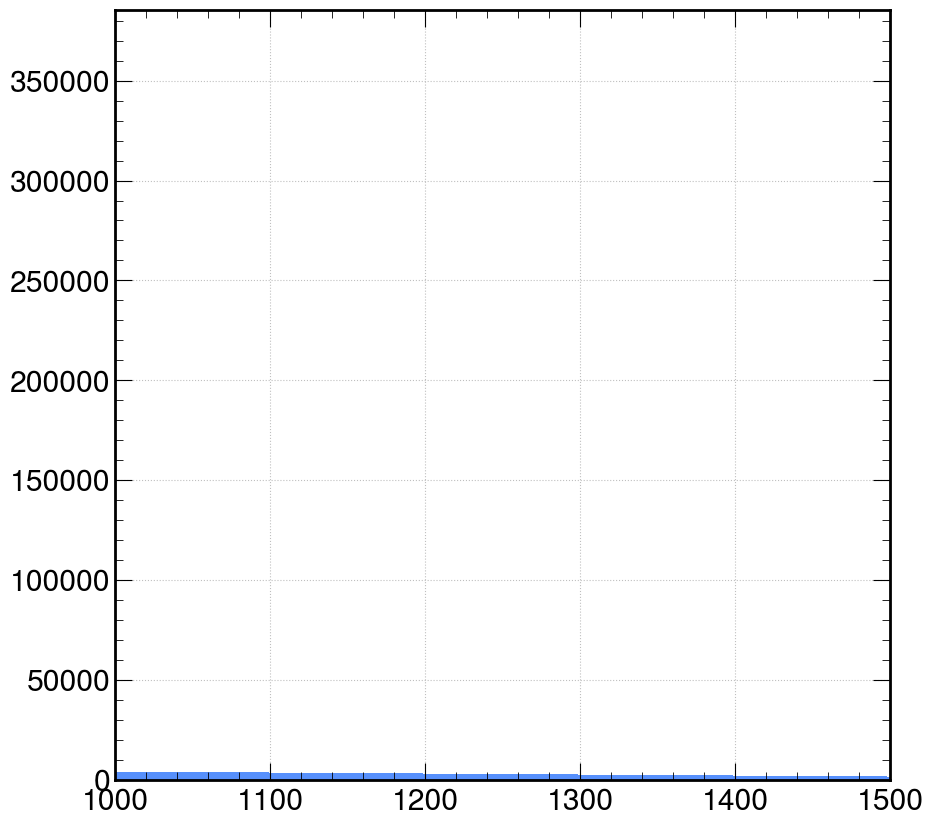

In [32]:
df_events.loc[df_events['PID'].isin([12, -12]), 'E'].hist(bins=50).set_xlim(1000, 1500)

In [33]:
df_events

,Unnamed: 0,PID,status,Mmother1,mother2,color1,color2,px,py,pz,...,M,Lifetime,Spin,Event_ID,cross_section,cross_section_error,Name,Symbol,neutrino,anti_neutrino
0,0,-1.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,26.295143,...,0.0,0.0,1.0,1.0,14.9448,0.005595,Anti-Down Quark,d~,-1,NaN
1,1,1.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-90.457148,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Down Quark,d,-1,NaN
2,2,12.0,1.0,1.0,2.0,0.0,0.0,13.148818,6.728541,-65.894337,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Electron Neutrino,ve,True,NaN
3,3,-12.0,1.0,1.0,2.0,0.0,0.0,-20.712857,-17.372946,14.740016,...,0.0,0.0,1.0,1.0,14.9448,0.005595,Electron Anti-Neutrino,ve~,-1,True
4,4,22.0,1.0,1.0,2.0,0.0,0.0,7.564039,10.644405,-13.007682,...,0.0,0.0,-1.0,1.0,14.9448,0.005595,Photon,a,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,4999995,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,22.371330,...,0.0,0.0,-1.0,1000000.0,14.9448,0.005595,Anti-Up Quark,u~,-1,NaN
4999996,4999996,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-152.764759,...,0.0,0.0,1.0,1000000.0,14.9448,0.005595,Up Quark,u,-1,NaN
4999997,4999997,14.0,1.0,1.0,2.0,0.0,0.0,-37.079267,-12.672226,-31.589324,...,0.0,0.0,-1.0,1000000.0,14.9448,0.005595,Muon Neutrino,vm,True,NaN
4999998,4999998,-14.0,1.0,1.0,2.0,0.0,0.0,36.702771,35.798366,-79.886091,...,0.0,0.0,1.0,1000000.0,14.9448,0.005595,Muon Anti-Neutrino,vm~,-1,True


array([[<Axes: title={'center': 'E'}>]], dtype=object)

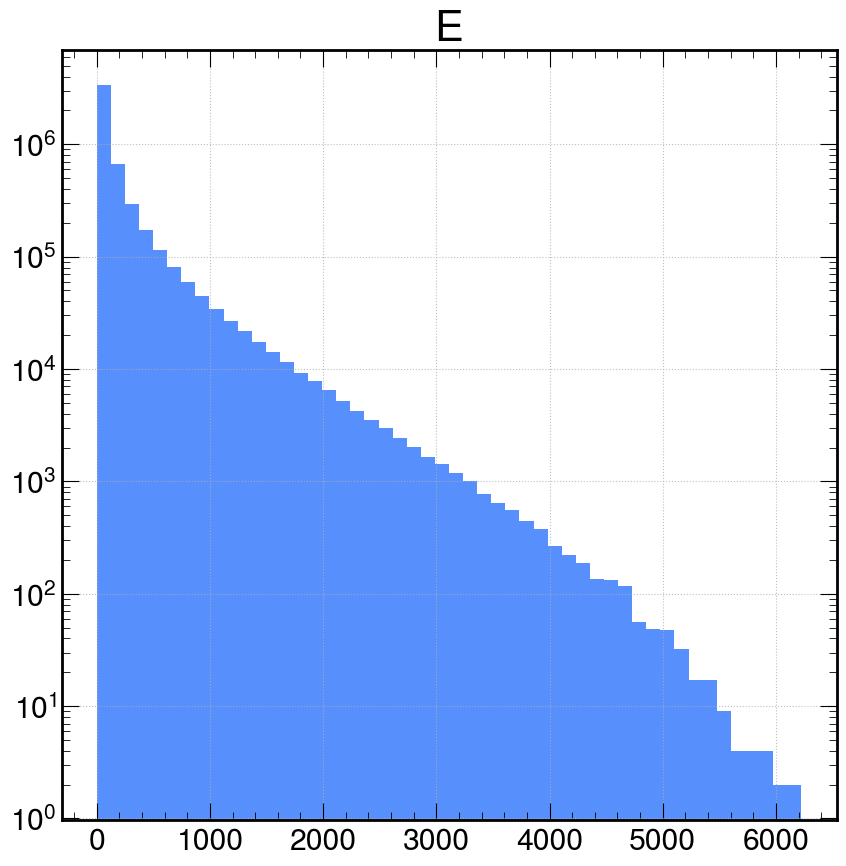

In [34]:
df_events.hist('E', bins=50, log=True)

In [ ]:
df_events

In [ ]:
df_events.merge(particle_df, on='PID', how='left')